In [23]:
import psycopg2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLars

from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import ValidationCurve

In [2]:
# Query modeling_data2 table from PostgreSQL database

try:
    conn = psycopg2.connect(user="cohort17",
                            password="Cohort17Movies",
                            host="moviesdb.ce8d6g1pa5lm.us-east-1.rds.amazonaws.com",
                            port="5432",database="moviesdb")

    dbquery = "select * from modeling_data2"
    
    movies = pd.read_sql_query(dbquery, conn)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    if(conn):
        conn.close()

In [24]:
model = load('models/gbm_randomsearch.joblib')
regressor = model.steps[-1][1]
model

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=False,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                            

In [45]:
X = movies.drop(['primarytitle','domesticgross'], axis=1)
y = movies['domesticgross']

numeric_features = X[['productionbudget','runtimeminutes','release_year','release_week']].columns
dummy_features = X.drop(numeric_features, axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [46]:
model.score(X_test, y_test)

0.5862917568828443

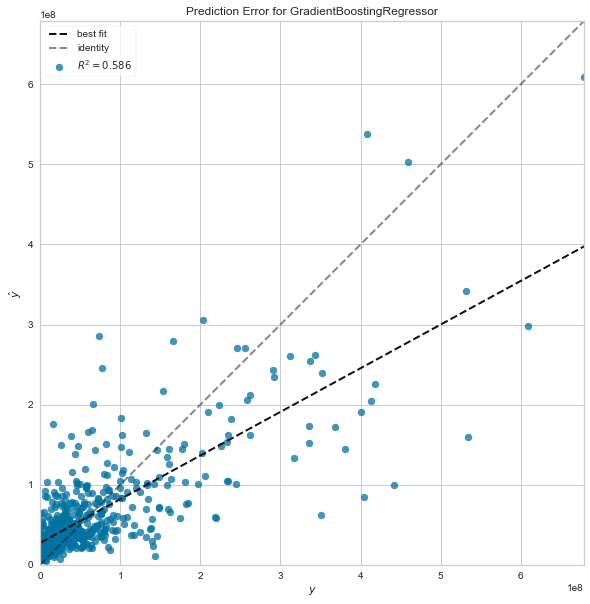

In [16]:
plt.figure(figsize=(8,8))
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

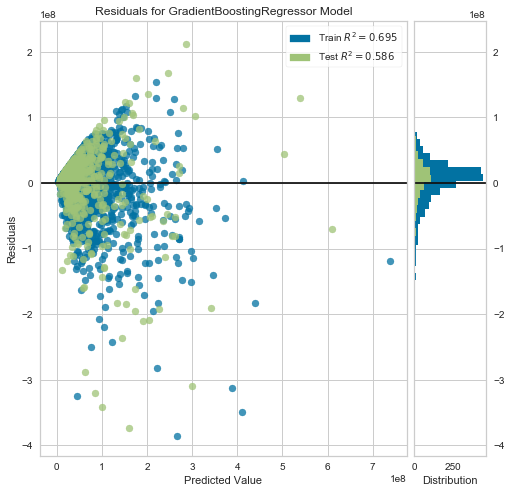

In [17]:
plt.figure(figsize=(8,8))
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

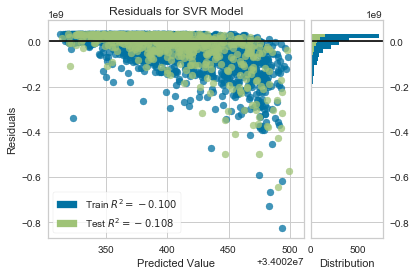

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


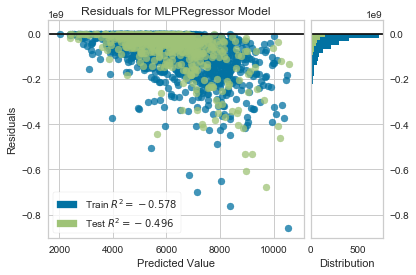

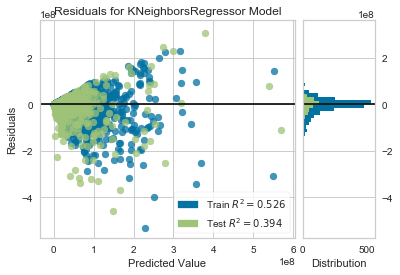

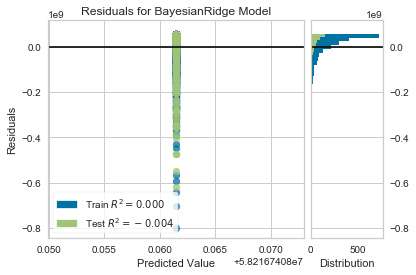

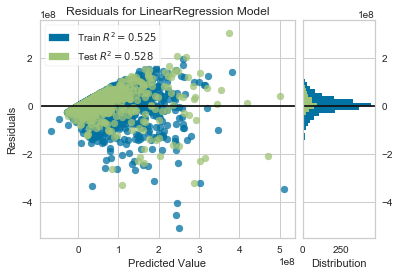

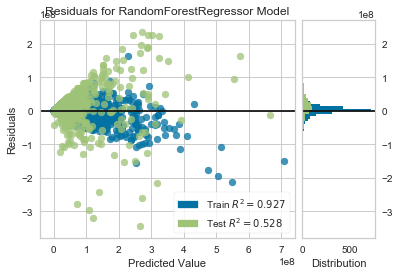

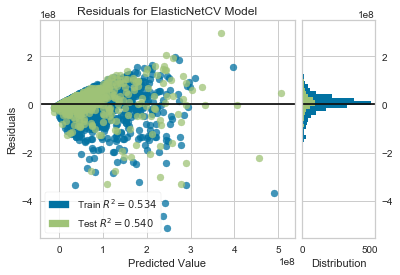

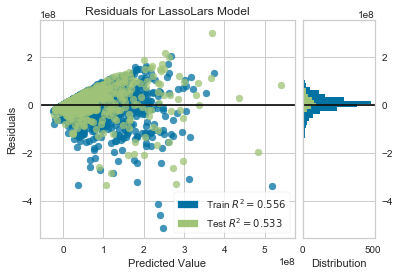

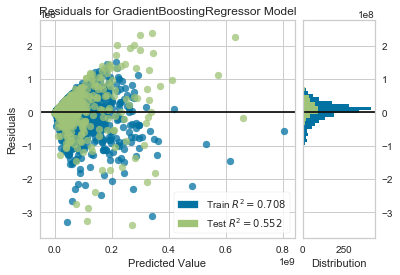

In [22]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression

impute_numeric = SimpleImputer(missing_values=np.nan, strategy='median', copy=False, fill_value=None)
impute_dummy = SimpleImputer(missing_values=np.nan, strategy='constant', copy=False, fill_value=0)

scale_numeric = MinMaxScaler(copy=False)

numeric_transformer = Pipeline(steps=[
    ('imputer', impute_numeric),
    ('scaler', scale_numeric)])

dummy_transformer = Pipeline(steps=[
    ('imputer', impute_dummy)])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('dum', dummy_transformer, dummy_features)])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
    "elastic net": ElasticNetCV(max_iter=1000, cv=5, random_state=0, l1_ratio=[.1, .3, .5, .7, .9, .95, .99, 1]),
    "lasso lars": LassoLars(max_iter=1000),
    "gradient boosting regressor": GradientBoostingRegressor(random_state=0)
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


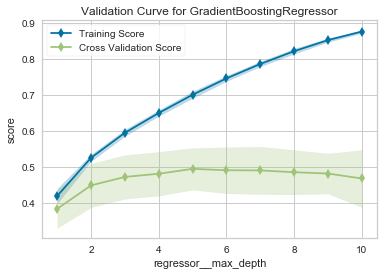

<Figure size 432x288 with 0 Axes>

In [37]:
viz = ValidationCurve(
    model, param_name="regressor__max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_max_depth.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


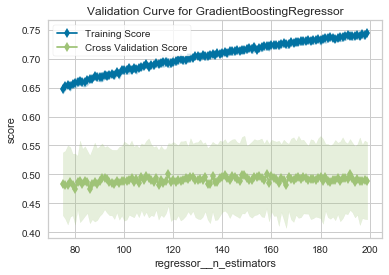

<Figure size 432x288 with 0 Axes>

In [38]:
viz = ValidationCurve(
    model, param_name="regressor__n_estimators",
    param_range=np.arange(75, 200), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_n_estimators.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


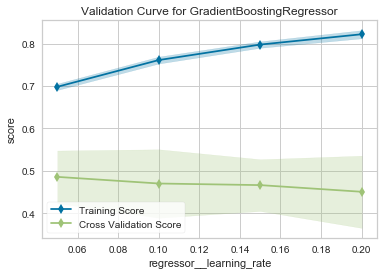

<Figure size 432x288 with 0 Axes>

In [39]:
viz = ValidationCurve(
    model, param_name="regressor__learning_rate",
    param_range=np.arange(.05, .25, .05), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_learning_rate.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


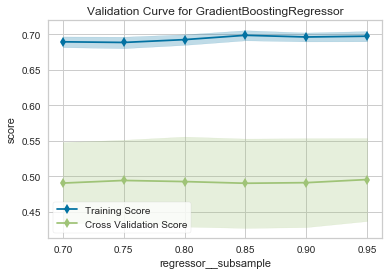

<Figure size 432x288 with 0 Axes>

In [40]:
viz = ValidationCurve(
    model, param_name="regressor__subsample",
    param_range=np.arange(.7, .99, .05), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/plotsvalidation_subsample.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


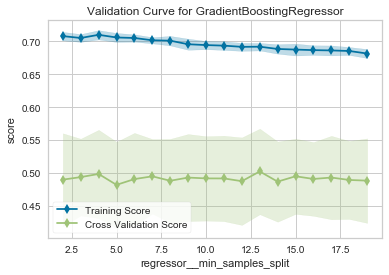

<Figure size 432x288 with 0 Axes>

In [41]:
viz = ValidationCurve(
    model, param_name="regressor__min_samples_split",
    param_range=np.arange(2, 20), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_min_samples_split.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


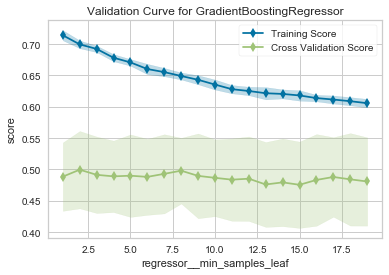

In [35]:
viz = ValidationCurve(
    model, param_name="regressor__min_samples_leaf",
    param_range=np.arange(1, 20), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_min_samples_leaf.png')

In [62]:
rf_model = load('rf_randomsearch.joblib')
rf_regressor = model.steps[-1][1]
rf_model

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from 

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle

AttributeError: module 'sklearn.utils.deprecation' has no attribute 'DeprecationDict'

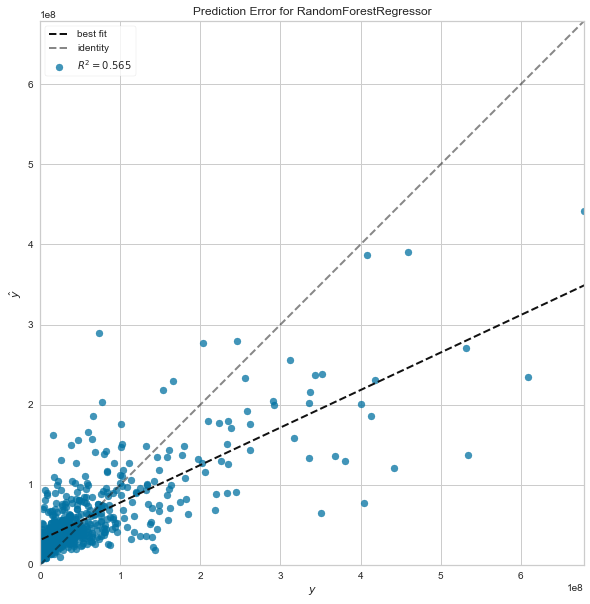

In [63]:
plt.figure(figsize=(8,8))
visualizer = PredictionError(rf_model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

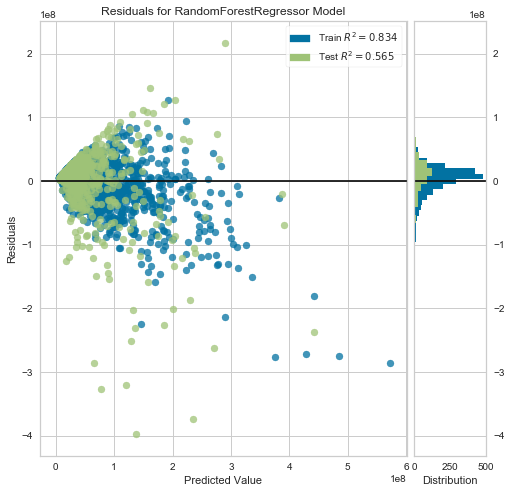

In [53]:
plt.figure(figsize=(8,8))
visualizer = ResidualsPlot(rf_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
viz = ValidationCurve(
    rf_model, param_name="regressor__max_depth",
    param_range=np.arange(10, 80), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/rf_validation_max_depth.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


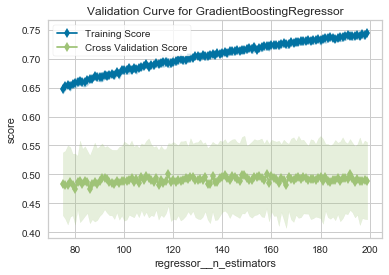

<Figure size 432x288 with 0 Axes>

In [38]:
viz = ValidationCurve(
    rf_model, param_name="regressor__n_estimators",
    param_range=np.arange(75, 200), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_n_estimators.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


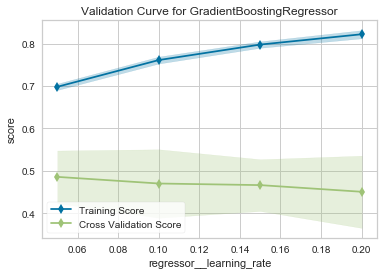

<Figure size 432x288 with 0 Axes>

In [39]:
viz = ValidationCurve(
    rf_model, param_name="regressor__max_features",
    param_range=np.arange(.05, .25, .05), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_learning_rate.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


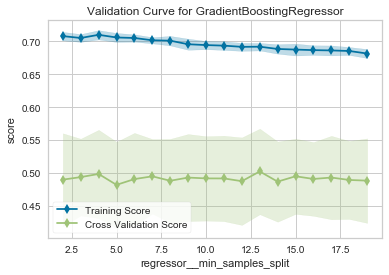

<Figure size 432x288 with 0 Axes>

In [41]:
viz = ValidationCurve(
    rf_model, param_name="regressor__min_samples_split",
    param_range=np.arange(2, 20), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_min_samples_split.png')

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


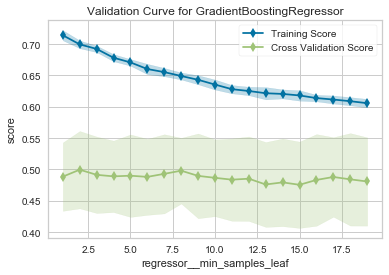

In [35]:
viz = ValidationCurve(
    rf_model, param_name="regressor__min_samples_leaf",
    param_range=np.arange(1, 20), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()
plt.savefig('plots/validation_min_samples_leaf.png')